Import Games of Elo ~1100

In [10]:
import pandas as pd 
import torch 
from torch.utils.data import Dataset
import dask.dataframe as dd 
import numpy as np
import torch.nn as nn
import math
import chess
import random
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence
import torch.nn.functional as F

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
# Import CSV File (from Maia: http://csslab.cs.toronto.edu/datasets/#monthly_chess_csv)
# The CSV has 151,072,060 rows
data_types ={'clock': 'float32',
       'cp': 'object',
       'opp_clock': 'float32',
       'opp_clock_percent': 'float32'}
df = dd.read_csv('../data/lichess_db_standard_rated_2019-01.csv', blocksize='64e6', dtype= data_types, low_memory=False)

# Filter out quick games (Bullet and HyperBullet) and take out moves that happened in the last XX seconds (this won't affect how many games we import but the # of moves we look at)
condition_time_control = ~df['time_control'].isin(['Bullet', 'HyperBullet'])
condition_clock = df['clock'] > 45
# condition_plays = df['num_ply'] < 80
filtered_df = df[condition_time_control & condition_clock]

# Select Relevant Columns
selected_columns = ['game_id','white_elo','black_elo','move','white_active','board']
filtered_df = filtered_df[selected_columns]

# Filter only games of Elo 1100-1199
filtered_df = filtered_df[(filtered_df['white_elo'].between(1500, 1599)) & (filtered_df['black_elo'].between(1500, 1599))]

# Group Same Games Together 
def aggregate_moves(group):
    moves = ' '.join(group['move'])  # Concatenate moves into a single string
    white_elo = group['white_elo'].iloc[0]  # Get the first white_elo
    black_elo = group['black_elo'].iloc[0]  # Get the first black_elo
    white_active = group['white_active'].iloc[0]  # Get the first num_ply
    board = '*'.join(group['board'])  # Get the first num_ply
    return pd.Series({'moves': moves, 'white_elo': white_elo, 'black_elo': black_elo, 'white_active': white_active, 'board': board})

grouped_df = filtered_df.groupby('game_id',sort=True).apply(aggregate_moves, meta={'moves': 'str', 'white_elo': 'int', 'black_elo': 'int', 'white_active': 'str', 'board': 'str'}).compute()

# This gives us 99,300 Games when we don't filter games with more than 80 half-moves
print(grouped_df)


                                                      moves  white_elo  \
game_id                                                                  
00VRM44j  e2e4 g8f6 e4e5 f6g8 f1b5 f7f6 e5e6 c7c6 e6d7 c...       1523   
0MG5pz3L  c2c4 g7g6 e2e4 f8g7 d2d3 d7d6 f1e2 g8f6 g1f3 e...       1538   
0MV7dmua  e2e4 e7e5 f2f4 e5f4 g1f3 d7d5 e4d5 d8d5 b1c3 d...       1587   
0UNsyqEb  d2d4 d7d5 c2c4 g8f6 b1c3 c8f5 c1g5 e7e6 e2e3 h...       1507   
10mypbCS  d2d4 g7g6 c1h6 f8h6 g1f3 g8f6 e2e3 b8c6 f1b5 d...       1500   
...                                                     ...        ...   
yckDW8pr  d2d4 d7d5 c1f4 c8f5 e2e3 e7e6 f1d3 f5g6 g1f3 g...       1520   
yjFqLLIM  d2d4 g8f6 c2c4 e7e6 g1f3 d7d5 e2e3 c7c6 b2b3 f...       1525   
yzgxpBPa  d2d4 d7d5 c2c4 e7e6 b1c3 g8f6 c1g5 f8b4 d1c2 b...       1532   
zHpwiwWK  e2e4 c7c5 g1f3 b8c6 f1b5 d7d6 e1g1 e7e5 c2c3 g...       1571   
zI8GQITc  e2e4 e7e5 g1f3 b8c6 f1b5 a7a6 b5a4 b7b5 a4b3 c...       1512   

          black_elo  white_active  \


In [3]:
grouped_df.to_csv('haha_longer_1500.csv')

In [33]:
grouped_df = pd.read_csv("haha_longer.csv")

In [4]:
print(grouped_df)

                                                      moves  white_elo  \
game_id                                                                  
00VRM44j  e2e4 g8f6 e4e5 f6g8 f1b5 f7f6 e5e6 c7c6 e6d7 c...       1523   
0MG5pz3L  c2c4 g7g6 e2e4 f8g7 d2d3 d7d6 f1e2 g8f6 g1f3 e...       1538   
0MV7dmua  e2e4 e7e5 f2f4 e5f4 g1f3 d7d5 e4d5 d8d5 b1c3 d...       1587   
0UNsyqEb  d2d4 d7d5 c2c4 g8f6 b1c3 c8f5 c1g5 e7e6 e2e3 h...       1507   
10mypbCS  d2d4 g7g6 c1h6 f8h6 g1f3 g8f6 e2e3 b8c6 f1b5 d...       1500   
...                                                     ...        ...   
yckDW8pr  d2d4 d7d5 c1f4 c8f5 e2e3 e7e6 f1d3 f5g6 g1f3 g...       1520   
yjFqLLIM  d2d4 g8f6 c2c4 e7e6 g1f3 d7d5 e2e3 c7c6 b2b3 f...       1525   
yzgxpBPa  d2d4 d7d5 c2c4 e7e6 b1c3 g8f6 c1g5 f8b4 d1c2 b...       1532   
zHpwiwWK  e2e4 c7c5 g1f3 b8c6 f1b5 d7d6 e1g1 e7e5 c2c3 g...       1571   
zI8GQITc  e2e4 e7e5 g1f3 b8c6 f1b5 a7a6 b5a4 b7b5 a4b3 c...       1512   

          black_elo  white_active  \


Now that we have our raw data, we need to be able to make sense of chess moves. Meaning, we're transforming our entire world from chess moves into numerical tokens that will serve as indices into unique embeddings

In [25]:
# First, generate a mapping from each move to a unique embedding. In order to index into our matrix of 
# embeddings (matrix format so it's something we can tune), we'll also want a mapping from each move to a unique ID
class Vocabulary:
    def __init__(self):
        self.move_to_id = {"<UNK>": 0}
        self.id_to_move = {0: "<UNK>"}
        self.index = 1  # Start indexing from 1

    def add_move(self, move):
        if move not in self.move_to_id:
            self.move_to_id[move] = self.index
            self.id_to_move[self.index] = move
            self.index += 1

    def get_id(self, move):
        return self.move_to_id.get(move, self.move_to_id["<UNK>"])

    def get_move(self, id):
        return self.id_to_move.get(id, self.id_to_move[0])

# We can just use nn.Embedding later when we pass the model a sequence of indices, but this is if we ever want to pre-train and have access to the matrix we've trained
def get_embedding_matrix(vocab, d_embed):
    n_embed = len(vocab.move_to_id)
    return np.random.normal(0, 1, (n_embed, d_embed))
# embedding_matrix = get_embedding_matrix(vocab, 64)
    
piece_to_index = {
    'p' : 0,
    'r' : 1,
    'b' : 2,
    'n' : 3,
    'q' : 4,
    'k' : 5,
}

def string_to_array(string):
    rows = string.split("/")
    ans = [[[0 for a in range(8)] for b in range(8)] for c in range(6)]
    for row in range(8):
        curr_row = rows[row]
        #print(curr_row)
        offset = 0
        for piece in range(len(curr_row)):
            curr_piece = curr_row[piece]
            sign = 1 if curr_piece.lower() == curr_piece else -1 # check if the piece is capitalized
            curr_piece = curr_piece.lower() # after storing whether or not capitalized, standardize it to lower case for easy processing
            if curr_piece not in piece_to_index.keys():
                offset += int(curr_piece) - 1
            else:
                current_board = ans[piece_to_index[curr_piece]]
                current_board[row][offset + piece] = 1 * sign
                ans[piece_to_index[curr_piece]] = current_board
    return ans

# Function to pad move sequences & get their sequence lengths
def pad_sequences(sequences, max_len=None, pad_id=0):
    if max_len is None:
        max_len = max(len(seq) for seq in sequences)
    padded_sequences = np.full((len(sequences), max_len), pad_id, dtype=int)
    sequence_lengths = np.zeros(len(sequences), dtype=int)
    for i, seq in enumerate(sequences):
        length = len(seq)
        padded_sequences[i, :length] = seq[:length]
        sequence_lengths[i] = length
    return padded_sequences, sequence_lengths

class MultimodalDataset(Dataset):
    def __init__(self, sequences, boards, lengths, labels):
        self.sequences = sequences
        self.boards = boards
        self.lengths = lengths
        self.labels = labels

    def __len__(self):
        return len(self.sequences)

    def __getitem__(self, idx):
        boards, sequences, lengths, labels = self.boards[idx], self.sequences[idx], self.lengths[idx], self.labels[idx]
        return torch.tensor(boards, dtype=torch.float32), torch.tensor(sequences, dtype=torch.long), torch.tensor(lengths, dtype=torch.long), torch.tensor(labels, dtype=torch.long)

In [5]:
def df_to_data(df, sampling_rate=1, fixed_window = True, fixed_window_size = 16, algebraic_notation=True):
    """
    Input: Dataframe of training data in which each row represents a full game played between players
    Output: List in which each item represents some game's history up until a particular move, List in the same order in which the associated label is the following move
    """
    board_states = []
    subsequences = []
    next_moves = []
    vocab = Vocabulary()
    chess_board = chess.Board()
    for game_board, game_moves in zip(df['board'],df['moves']):
        moves = game_moves.split()
        boards = game_board.split('*')
        # Encode the moves into SAN notation and then into corresponding indices
        encoded_moves = []
        for move in moves:
            # Create a move object from the coordinate notation
            move_obj = chess.Move.from_uci(move)
            if move_obj not in chess_board.legal_moves:
                break 
            else:
                if algebraic_notation:
                    algebraic_move = chess_board.san(move_obj)
                    chess_board.push(move_obj)
                    vocab.add_move(algebraic_move)
                    encoded_move = vocab.get_id(algebraic_move)
                    encoded_moves.append(encoded_move)
                else:
                    encoded_move = vocab.get_id(move)
                    encoded_moves.append(encoded_move)
        chess_board.reset()
        boards = boards[:len(encoded_moves)]
        # Now generate X,Y with sampling
        for i in range(len(encoded_moves)-1):
            #TODO: Figure out how to deal with black orientation 'seeing' a different board
            if random.uniform(0, 1) <= sampling_rate and 'w' in boards[i]:
                # Board
                board_states.append(string_to_array(boards[i].split(' ')[0]))
                # Sequence of Moves
                subseq = encoded_moves[0:i+1]
                if fixed_window and len(subseq) > fixed_window_size:
                    subseq = subseq[-fixed_window_size:]
                subsequences.append(subseq)
                # Label
                label = encoded_moves[i+1]
                next_moves.append(label)

    return subsequences, board_states, next_moves, vocab

In [35]:
trainX_sequences, trainX_boards, trainY, vocab = df_to_data(grouped_df, fixed_window=True, sampling_rate=0.75)
trainX_sequences, trainX_seqlengths  = pad_sequences(trainX_sequences)

In [36]:
print(len(vocab.id_to_move.keys()))
print(len(trainX_sequences[140]))

5690
16


In [37]:
print(len(trainX_boards))

1720664


In [56]:
class MultiModal(nn.Module):
    def __init__(self, vocab, d_embed, d_hidden, d_out, dropout = 0.5) -> None:
        super().__init__()
        self.rnn = RNNModel(vocab,d_embed, d_hidden, 16, dropout=dropout)
        self.cnn = ChessCNN(16)
        self.fc = nn.Linear(16*2,d_out)

    def forward(self, board, sequence, seq_lengths):
        seq_encoding = self.rnn(sequence, seq_lengths)
        cnn_encoding = self.cnn(board)
        pred = self.fc(torch.cat((seq_encoding,cnn_encoding),dim=1))
        return pred

class RNNModel(nn.Module):
    def __init__(self, vocab, d_embed, d_hidden, d_out, dropout = 0.5, num_layers = 2, bidirectional = False, embedding_matrix = None):
        super(RNNModel, self).__init__()
        self.embeddings = nn.Embedding(len(vocab.move_to_id), d_embed)
        # self.embeddings = nn.Embedding.from_pretrained(embedding_matrix, freeze=False)
        self.lstm = nn.LSTM(d_embed, d_hidden, dropout = dropout, bidirectional=bidirectional, num_layers = num_layers)
        self.fc = nn.Sequential(
            nn.Linear(d_hidden,d_out)
        )

    def forward(self, x, seq_lengths):
        x = self.embeddings(x)
        # Sort x and seq_lengths in descending order
        # This is required for packing the sequence
        seq_lengths, perm_idx = seq_lengths.sort(0, descending=True)
        x = x[perm_idx]
        # Pack the sequence
        packed_input = pack_padded_sequence(x, seq_lengths, batch_first=True)
        # Pass the packed sequence through the LSTM
        packed_output, (hidden, cell) = self.lstm(packed_input)

        # Unpack the sequence
        output, _ = pad_packed_sequence(packed_output, batch_first=True,total_length = x.size()[1])
        _, unperm_idx = perm_idx.sort(0)
        #unperm_idx = unperm_idx.to(self.device)
        output = output.index_select(0, unperm_idx)
        #This takes all the outputs across the cells
        mean_pooled = torch.mean(output, dim=1)
        #output = torch.cat((mean_pooled,hidden[-1]),dim=1)
        output = self.fc(mean_pooled)
        return output

        
class ChessCNN(nn.Module):
    def __init__(self, d_out):
        super(ChessCNN, self).__init__()
        # Assuming each channel represents a different piece type (e.g., 6 channels for 6 types each)
        self.conv1 = nn.Conv2d(6, 36, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(36)  # Batch normalization for first conv layer
        self.conv2 = nn.Conv2d(36, 64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)  # Batch normalization for second conv layer
        self.fc1 = nn.Linear(64 * 8 * 8, 128)  # Assuming an 8x8 chess board
        self.fc2 = nn.Linear(128, d_out)

    def forward(self, x):
        # Apply first convolution, followed by batch norm, then ReLU
        x = F.relu(self.bn1(self.conv1(x)))
        # Apply second convolution, followed by batch norm, then ReLU
        x = F.relu(self.bn2(self.conv2(x)))

        # Flatten the tensor
        x = x.view(x.size(0), -1)

        # Apply fully connected layers
        x = F.relu(self.fc1(x))
        x = self.fc2(x)

        return x

In [13]:
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, Subset
import torch.optim as optim
from torch.optim.swa_utils import AveragedModel

Functions for training

In [48]:
# Function to calculate top-3 accuracy
def top_3_accuracy(y_true, y_pred):
    top3 = torch.topk(y_pred, 3, dim=1).indices
    correct = top3.eq(y_true.view(-1, 1).expand_as(top3))
    return correct.any(dim=1).float().mean().item()

def train(device, model, train_loader, val_loader, criterion, optimizer, num_epochs, learn_decay):
    train_loss_values = []
    train_error = []
    val_loss_values = []
    val_error = []
    val_3_accuracy = []
    for epoch in range(num_epochs):
        train_correct = 0
        train_total = 0
        training_loss = 0.0
        # Training
        model.train()
        count = 0
        for boards, sequences, lengths, labels in train_loader:
            count += 1
            boards, sequences, lengths, labels = boards.to(device), sequences.to(device), lengths.to(device), labels.to(device)
            # Forward Pass
            output = model(boards, sequences, lengths)
            loss = criterion(output, labels)
            # Backpropogate & Optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            # For logging purposes
            training_loss += loss.item()
            _, predicted = torch.max(output.data, 1)
            train_total += labels.size(0)
            train_correct += (predicted == labels).sum().item()
            if count % 1000 == 0:
                print(f'Epoch {epoch+1}, Batch: {count}| Training Loss: {training_loss/count}')
        # Validation
        model.eval()
        val_correct = 0
        val_total = 0
        validation_loss = 0.0
        if val_loader is not None:
            with torch.no_grad():
                val_correct = 0
                val_total = 0
                val_top3_correct = 0
                validation_loss = 0

                for boards, sequences, lengths, labels in val_loader:
                    boards, sequences, lengths, labels = boards.to(device), sequences.to(device), lengths.to(device), labels.to(device)
                    outputs = model(boards, sequences, lengths)
                    _, predicted = torch.max(outputs.data, 1)
                    val_total += labels.size(0)
                    val_correct += (predicted == labels).sum().item()
                    val_top3_correct += top_3_accuracy(labels, outputs) * labels.size(0)
                    loss = criterion(outputs, labels)
                    validation_loss += loss.item()

                val_loss_values.append(validation_loss / len(val_loader))
                val_accuracy = 100 * val_correct / val_total
                val_top3_accuracy = 100 * val_top3_correct / val_total
                val_error.append(100 - val_accuracy)
                val_3_accuracy.append(val_top3_accuracy)

        # Log Model Performance  
        train_loss_values.append(training_loss)
        train_error.append(100-100*train_correct/train_total)
        print(f'Epoch {epoch+1}, Training Loss: {training_loss/len(train_loader)}, Validation Error: {val_error[-1]}, Validation Top-3 Accuracy: {val_3_accuracy[-1]}, Training Error: {train_error[-1]}')
        if epoch <= 10 or epoch >= 23:
            for op_params in optimizer.param_groups:
                op_params['lr'] = op_params['lr'] * learn_decay
    return train_error,train_loss_values, val_error, val_loss_values

Now let's train

In [39]:
dataset = MultimodalDataset(trainX_sequences, trainX_boards, trainX_seqlengths, trainY)
# Calculate split sizes
total_size = len(dataset)
print(total_size)

1720664


# Experiments

## Experiment 1

In [40]:
# We're scaling the model size so let's bring in more data as well
train_size = int(0.95 * total_size)
val_size = int(total_size * 0.04)

# Create subsets for training and validation
train_dataset = Subset(dataset, range(0, train_size))
val_dataset = Subset(dataset, range(train_size, train_size + val_size))
print(train_size)

1634630


In [57]:
# Reload the data with particular batch size
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

# Initialize model, loss function, and optimizer
d_hidden = 72
d_embed = 32
NUM_EPOCHS = 25
d_out = len(vocab.id_to_move.keys())
model = MultiModal(vocab,d_embed,d_hidden,d_out) 
model = model.to(device)
criterion = nn.CrossEntropyLoss()
lr = 2e-3
weight_decay=1e-7
learn_decay = 0.7 # This causes the LR to be 2e-5 by epoch 10
optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)
print(count_parameters(model))

993054


Epoch 1, Batch: 1000| Training Loss: 5.3776393618583676
Epoch 1, Batch: 2000| Training Loss: 5.148660890340805
Epoch 1, Batch: 3000| Training Loss: 5.008869136333465
Epoch 1, Batch: 4000| Training Loss: 4.90768612074852
Epoch 1, Batch: 5000| Training Loss: 4.822340172863006
Epoch 1, Batch: 6000| Training Loss: 4.755600390513738
Epoch 1, Batch: 7000| Training Loss: 4.701854768855231
Epoch 1, Batch: 8000| Training Loss: 4.6509501395523545
Epoch 1, Batch: 9000| Training Loss: 4.608193051099777
Epoch 1, Batch: 10000| Training Loss: 4.568666521668434
Epoch 1, Batch: 11000| Training Loss: 4.532528639186513
Epoch 1, Batch: 12000| Training Loss: 4.498760126252969
Epoch 1, Batch: 13000| Training Loss: 4.468972160651133
Epoch 1, Batch: 14000| Training Loss: 4.4421408867836
Epoch 1, Batch: 15000| Training Loss: 4.417240078322092
Epoch 1, Batch: 16000| Training Loss: 4.394133803024888
Epoch 1, Batch: 17000| Training Loss: 4.373170186645845
Epoch 1, Batch: 18000| Training Loss: 4.35459246439404
Epo

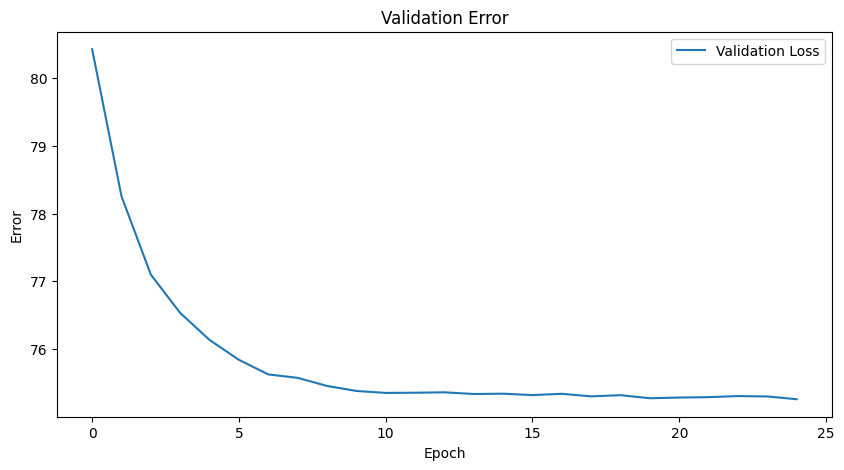

<Figure size 640x480 with 0 Axes>

In [58]:
# Train the model
train_error,train_loss_values, val_error, val_loss_value = train(device, model, train_loader, val_loader, criterion, optimizer, NUM_EPOCHS, learn_decay)

# Plot the training error
plt.figure(figsize=(10, 5))
plt.plot(val_error, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Error')
plt.title('Validation Error')
plt.legend()
plt.show()
plt.savefig('validation_error_model_rnn.png')  # This will save the plot as an image

What happens if we filter out illegal moves in our prediction?

In [63]:
def is_legal_move(chess_board, move_san):
    try:
        chess_move = chess_board.parse_san(move_san)
        return chess_move in chess_board.legal_moves
    except ValueError:
        # This handles cases where the SAN move cannot be parsed or is not legal
        return False

def load_board_state_from_san(moves):
    board = chess.Board()
    for index in moves:
        try:
            if index == 0:
                return board
            else:
                move_san = vocab.get_move(index.item())
                move = board.parse_san(move_san)
                board.push(move)
        except ValueError:
            # Handle invalid moves, e.g., break the loop or log an error
            break
    return board

val_size = int(total_size * 0.04)
val_dataset = Subset(dataset, range(train_size, train_size + val_size))
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)

model.eval()
val_correct = 0
val_total = 0

if val_loader is not None:
    with torch.no_grad():
        for boards, sequences, lengths, labels in val_loader:
            boards, sequences, lengths, labels = boards.to(device), sequences.to(device), lengths.to(device), labels.to(device)
            outputs = model(boards, sequences, lengths)
            probabilities = torch.softmax(outputs, dim=1)
            minus = 0
            for idx, (sequence, label) in enumerate(zip(sequences, labels)):
                # This tells us we're looking at games that include the opening but has developed more than the first 4 half-moves
                if sequence[-1].item() == 0 and sequence[2].item() != 0 and sequence[3].item() != 0 and sequence[4].item() != 0:
                    output = probabilities[idx]
                    sorted_probs, sorted_indices = torch.sort(output, descending=True)
                    predicted_move = sorted_indices[0]
                    # print(predicted_move)
                    chess_board = load_board_state_from_san(sequence)
                    for move_idx in sorted_indices:
                        move = vocab.get_move(move_idx.item()) # Convert index to move (e.g., 'e2e4')
                        if is_legal_move(chess_board, move):
                            # print("we found one")
                            predicted_move = vocab.get_id(move)
                            break
                    
                    # Check if predicted move is correct
                    correct_move = label.item() # Convert label to move
                    # print(correct_move)
                    if predicted_move == correct_move:
                        val_correct += 1
                else:
                    minus += 1
            val_total += (labels.size(0) - minus)

        val_accuracy = 100 * val_correct / val_total
        print(f"Validation Accuracy: {val_accuracy}%")


hey
hey
hey
hey
hey
hey
hey
hey
hey
hey
hey
hey
hey
hey
hey
hey
hey
hey
hey
hey
hey
hey
hey
hey
hey
hey
hey
hey
hey
hey
hey
hey
hey
hey
hey
hey
hey
hey
hey
hey
hey
hey
hey
hey
hey
hey
hey
hey
hey
hey
hey
hey
hey
hey
hey
hey
hey
hey
hey
hey
hey
hey
hey
hey
hey
hey
hey
hey
hey
hey
hey
hey
hey
hey
hey
hey
hey
hey
hey
hey
hey
hey
hey
hey
hey
hey
hey
hey
hey
hey
hey
hey
hey
hey
hey
hey
hey
hey
hey
hey
hey
hey
hey
hey
hey
hey
hey
hey
hey
hey
hey
hey
hey
hey
hey
hey
hey
hey
hey
hey
hey
hey
hey
hey
hey
hey
hey
hey
hey
hey
hey
hey
hey
hey
hey
hey
hey
hey
hey
hey
hey
hey
hey
hey
hey
hey
hey
hey
hey
hey
hey
hey
hey
hey
hey
hey
hey
hey
hey
hey
hey
hey
hey
hey
hey
hey
hey
hey
hey
hey
hey
hey
hey
hey
hey
hey
hey
hey
hey
hey
hey
hey
hey
hey
hey
hey
hey
hey
hey
hey
hey
hey
hey
hey
hey
hey
hey
hey
hey
hey
hey
hey
hey
hey
hey
hey
hey
hey
hey
hey
hey
hey
hey
hey
hey
hey
hey
hey
hey
hey
hey
hey
hey
hey
hey
hey
hey
hey
hey
hey
hey
hey
hey
hey
hey
hey
hey
hey
hey
hey
hey
hey
hey
hey
hey
hey
hey
hey
hey
hey


In [ ]:
torch.save(model.state_dict(), 'multimodalmodel.pth')